In [1]:
import numpy as np
import matplotlib.pyplot as plt
from funky import *
import scipy

In [2]:
import funkygigi as f

In [3]:
f.sim_wrapper_hubble([0.34,-1], 'hehehehe')

The .exe finished running successfully!
Here is what the .exe output: 
 Full command: snlc_sim.exe /home/ubuntu/SNANA/custom_input_files/sim_SDSS_custom.input GENVERSION hehehehe OMEGA_MATTER 0.34 w0_LAMBDA -1 

 SNANA_VERSION: 96036915



 ****************************************************************** 
   Begin execution of snlc_sim.exe    
 SNDATA_ROOT = /home/ubuntu/SNANA/SNROOT 
 SNANA_DIR   = /home/ubuntu/SNANA/SNDIR 


   sizeof(INPUTS) =   5.247 MB 
   sizeof(GENLC)  =  17.393 MB 

  init_SNDATA_GLOBAL: 
 --------------------------------------------------------
  Initialize NstringMatch for sim-input file
  Read 87 words from user input file 1: 
	 /home/ubuntu/SNANA/custom_input_files/sim_SDSS_custom.input 

 ****************************************************************** 
   init_HzFUN_INFO  
	 H0         = 65.00      # km/s/Mpc 
	 OM, OL, Ok = 0.34000, 0.68500, -0.02500 
	 w0, wa     = -1.000,  0.000 

 ****************************************************************** 

(array([40.86629, 39.29054, 39.41291, 38.99526, 39.76935, 40.12467,
        41.57593, 40.6202 , 39.75603, 40.55381, 41.92014, 39.68443]),
 array([0.25816, 0.13551, 0.1604 , 0.12202, 0.18327, 0.20269, 0.36033,
        0.25635, 0.17838, 0.25808, 0.39674, 0.17022]))

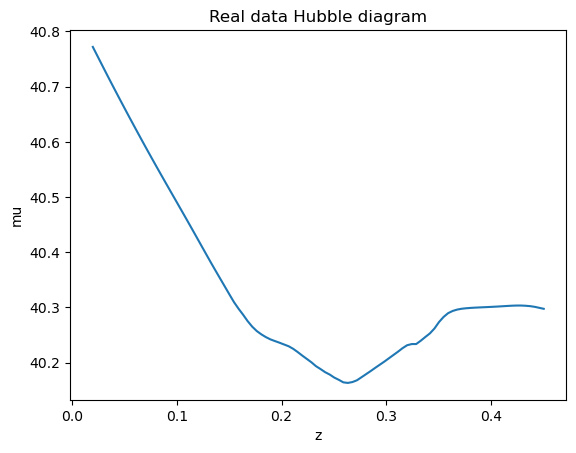

In [ ]:
# Estrazione mu e z per dati reali. Alla fine verrà una smooth curve su una 
# griglia uniforme di z.
#z_data,mu_data=get_hubble_real()
z_data,mu_data=get_hubble_sim([0.34,-1])
# summary statistic of real data
z_data,mu_data=(smoother(z_data,mu_data))


plt.plot(z_data,mu_data)
plt.title('Real data Hubble diagram')
plt.xlabel('z')
plt.ylabel('mu')
plt.show()

In [25]:
# errore si deve aggiornare a ogni trial
# observed data: nel paper sono 200 sampled SNe con omega m =0.27 e w = -1. Ho=72 km s-1 mpc-1.
N=500    


w=np.repeat(1/N,repeats=N)
theta_1=[]
distances=[]

#iterazione t = 1
while len(theta_1)<N:

    # Sample from prior: uniform over 0 < omega < 1, -3 < w < 0.
    theta=np.array([rng.uniform(0,1), rng.uniform(-3,0)])

    # simulate z and mu given choice of theta
    z_1, mu_1= get_hubble_sim(theta)
    # create summary statistics
    _,mu_1=(smoother(z_1,mu_1))
    # compute delta from summary stat. of real data
    delta = np.median(np.abs(mu_data - mu_1))

    # build array
    theta_1.append(theta)
    distances.append(delta)
# final array of 500 particles to perturb.    
theta_t=np.array(theta_1)

# TAU
tau_square=2*np.cov(theta_t, rowvar=False)

In [26]:
epsilon_t = np.percentile(distances,q=0.25)

#for t in range(2,T):
while epsilon_t > 0.033:
    theta_new=[] # diventerà il nuovo theta_t
    weights_new=[] # diventeranno il nuovo w
    distances_new=[]

    # Voglio N particles che mi piacciono. Alla fine aggiornerò pesi e epsilon
    for i in range(N):
        print(i)
        while True:
            # sample particle
            idx=rng.choice(range(N),p=w)
            theta_star=theta_t[idx]
            #perturb particle!
            theta_i_t=rng.multivariate_normal(theta_star, tau_square) # propongo un aggiornamento di un theta
            # scarto se sono fuori dal dominio
            if not ((0<theta_i_t[0]<1) and (-3<theta_i_t[1]<0)): continue
            #print(theta_i_t)
            # simulate z and mu given choice of theta
            z_i_t, mu_i_t= get_hubble_sim(theta_i_t)
            # create summary statistics
            _,mu_i_t=smoother(z_i_t,mu_i_t)

            # compute distance from summary stat. of real data
            delta = np.median(np.abs(mu_data - mu_i_t))
            
            if delta<epsilon_t:
                print('accettato',theta_i_t)
                break  #Ho trovato una particle che mi piace.
            else: print('rifiutato')

        theta_new.append(theta_i_t)
        distances_new.append(delta)

        # aggiorna pesi ---- DA RICONTROLLARE
        denom = 0.0
        for j in range(N):
            denom += w[j] * scipy.stats.multivariate_normal.pdf(x=theta_i_t,mean=theta_t[j],cov=tau_square)
        weight = 1 / denom
        weights_new.append(weight)


    ### Ora ho N particles che mi piacciono. Aggiorno tutto

    # w update
    weights_new=np.array(weights_new)
    w = weights_new / np.sum(weights_new)

    # theta_t update
    theta_t=np.array(theta_new)
    
    #epsilon update
    epsilon_t= np.quantile(distances_new,p=0.50)

# è finita. Ho il mio vettore theta di 500 particelle che seguono la posterior.
tau_square=2*np.cov(theta_t.T,aweights=w,bias=False)

In [28]:
print(theta_t)
print(tau_square)

[[ 0.52743748 -0.76087703]
 [ 0.94358035 -0.87961414]
 [ 0.8336103  -0.03585432]
 [ 0.89688138 -1.97096418]
 [ 0.32032063 -0.19992472]
 [ 0.04706715 -0.57876787]
 [ 0.87960881 -0.48579867]
 [ 0.93050264 -0.5813318 ]
 [ 0.11108585 -1.99362159]
 [ 0.62246831 -2.49063358]
 [ 0.71483532 -2.33994413]
 [ 0.96407544 -1.41664817]
 [ 0.42316513 -2.89657045]
 [ 0.53735163 -2.79118182]
 [ 0.49319968 -1.4195346 ]
 [ 0.35537226 -1.95787942]
 [ 0.44760765 -1.21873389]
 [ 0.86412945 -0.48044645]
 [ 0.68678    -0.07647678]
 [ 0.26494368 -1.47759319]
 [ 0.24651122 -1.41862986]
 [ 0.71875295 -2.04533847]
 [ 0.54900594 -1.03205924]
 [ 0.06683288 -0.75294023]
 [ 0.37217334 -1.95649365]
 [ 0.46584882 -2.62347724]
 [ 0.75748993 -0.71345409]
 [ 0.78428188 -0.73548172]
 [ 0.76119457 -1.92409476]
 [ 0.49448929 -0.44251354]
 [ 0.31352394 -0.52141788]
 [ 0.86506686 -1.31081776]
 [ 0.32819439 -2.54176706]
 [ 0.91339727 -0.74805714]
 [ 0.62892683 -0.37396984]
 [ 0.02864269 -2.58026603]
 [ 0.53951182 -0.26547313]
 

## TRASH

In [ ]:
#### simulazione dummy di z_phot, z_spec per 1744 SNe

z_spec=rng.uniform(0,0.45,size=1744)
z_phot=z_spec+ rng.normal(0.001,0.05,size=1744)
z_phot[z_phot<0]=0.001
z_phot[z_phot>0.45]=0.45
plt.scatter(z_spec,z_phot,c='orange')
plt.xlabel('spec z')
plt.ylabel('photo z')
plt.show()

In [ ]:
# snana per simulare sets di supernovae da diverse cosmologie.

#
# collezione di  500 particelle, viene migrata nel corso dell'algoritmo.
# poi scelgo a random una particella e la perturbo. Simulation data: 200 (z,z') pairs, sampling
# with replacement, da collezione di 500 particelle sopra. Con 200 true redshifts e theta i specificato
# allora calcoliamo il modulo di distanza. Aggiungiamo incertezza usando una Gaussian PDF con sigma= 0.04.
# gli observable data comprise the xti that appear nell'algoritmo. #

# summary statistic: applico un nonparametric regression smoother (5b), check appendice


# real data: per ogni curva, prendiamo 7 punti, prendiamo 103 sne sdss.
# simulated data: selection cuts e misuro il distance modulus.

# similarity delta: facciamo smooth dei due datasets e poi la median absolute deviation.
# fissiamo H0 a 65
# epsilon t: varia da iterazione a iterazione
# scegliamo N=150 particles e facciamo runnare il codice.




# Praticamente (z,z') mi serve solo nel primo esempio finto. 
# Mentre nell'altro caso, quello che vogliamo fare noi, penso lo faccia SNANA di simularsi un 
# redshift dalla power law.#

#            idx_z=rng.choice(range(z_phot),size=200,replace=True)
#            z_spec_i=z_spec[idx]
#            z_phot_i=z_phot[idx]
